In [4]:
import argparse, json, re
from Bio import SeqIO, Phylo
import pandas as pd
from string import digits
from itertools import groupby, count
from collections import defaultdict, Counter
from matplotlib import pyplot as plt

Text(0, 0.5, 'amount of mutations')

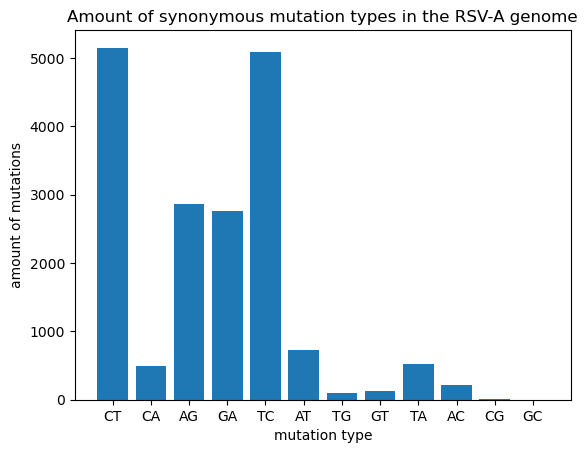

In [5]:
ref = SeqIO.read("data/areference.gbk", "genbank")
def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))

        if feature.type == 'source':everything = list(feature.location)

    #not_cds = list(set(everything)-set(cds_))
    #corrected_CDS = [x for x in cds_ if x<=14900]
    #corrected_not_CDS = [x for x in not_cds if x<=14900]
    return(cds_)
gene_cds = CDS_finder(ref)
#print(gene_cds)
def mutation_recursive(node, dictionary_=None, new_=None):
    """ this function returns a dictionary with node name as key and a list of mutations along that branch as the info"""
    gene_cds = CDS_finder(ref)
    

    if new_ is None:
        new_ = []
    if dictionary_ is None:
        dictionary_ = dict()

    if 'mutations' in node['branch_attrs']:
        aa_mutations = []
        new_ = []
        in_it = []
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0])
            #print(len(aa_mutations))

            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
             
    if 'name' in node:
            dictionary_[node['name']] = new_

    if 'children' in node:
        for child in node['children']:
           mutation_recursive(child, dictionary_, new_=None)
    
    return(dictionary_)
           
all_muts = []
mut_in_gene = defaultdict(list)


# all CDS 
gene_cds = CDS_finder(ref)
lst_cds = []
for gene, cds in gene_cds.items():
    for i in cds:
        lst_cds.append(int(i))
   

with open ("data/rsv_a_genome.json") as file_:
    f = json.load(file_)  
    mut_by_node = mutation_recursive(f['tree'])

    for node, muts in mut_by_node.items():
        for m in muts:
            if int(m[1:-1]) in lst_cds:
                all_muts.append(f'{m[0]}{m[-1]}')
for_graph = Counter(all_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A genome")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")
#gene_cds = CDS_finder(ref)
#for gene, cds in gene_cds.items():
    #for mut in all_muts:
        #if int(mut[1:-1]) in cds:
            #mut_in_gene[gene].append(mut)
         

Text(0, 0.5, 'amount of mutations')

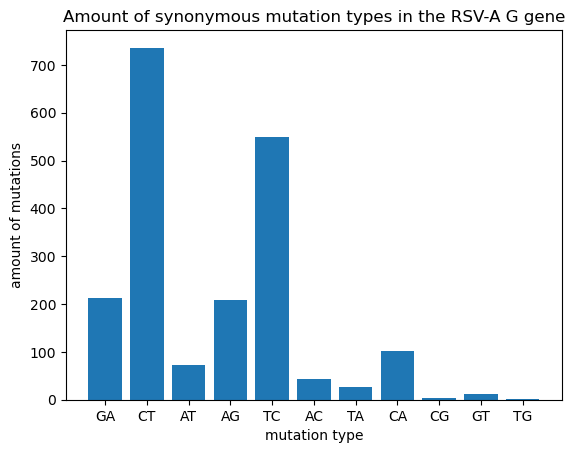

In [6]:
ref = SeqIO.read("data/areference.gbk", "genbank")
def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))
        #if feature.type == 'source':everything = list(feature.location)
    return(cds_)
gene_cds = CDS_finder(ref)

def mutation_recursive(node, dictionary_=None, new_=None):
    """ this function returns a dictionary with node name as key and a list of mutations along that branch as the info"""
    gene_cds = CDS_finder(ref)
    if new_ is None:
        new_ = []
    if dictionary_ is None:
        dictionary_ = dict()

    if 'mutations' in node['branch_attrs']:
        aa_mutations = []
        new_ = []
        in_it = []
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0])

            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
             
    if 'name' in node:
            dictionary_[node['name']] = new_

    if 'children' in node:
        for child in node['children']:
           mutation_recursive(child, dictionary_, new_=None)
    return(dictionary_)


gene_cds = CDS_finder(ref)
G_muts = []
mut_in_gene = defaultdict(list)
with open ("data/rsv_a_genome.json") as file_:
    f = json.load(file_)  
    mut_by_node = mutation_recursive(f['tree'])

    for node, muts in mut_by_node.items():
        for m in muts:
            if int(m[1:-1]) in range(int(gene_cds["G"][0]), int(gene_cds["G"][-1])+1):
                G_muts.append(f'{m[0]}{m[-1]}')
for_graph = Counter(G_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

In [134]:
from collections import Counter
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import argparse
from Bio import Phylo

def GenesAndCodons(aa_muts, nt_muts):
    codons=[]
    mutations_all = []
    all_genes =[] 
    with open(aa_muts) as a_muts:
        with open(nt_muts) as n_muts:
            dictofgenes=dict()
            aamuts = json.load(a_muts)
            ntmuts = json.load(n_muts)
            genes = ('F','G','M','M2','NS1','NS2','P','SH','N') #genes in RSV

            for gene in genes:
                for key, node in aamuts['annotations'].items():
                    if key == gene:
                        location_of_gene=[]
                        #mutation_in_gene =
                        location_of_gene = list(range(node['start'],node['end']+1)) #where each gene starts and ends
                dictofgenes[gene]=location_of_gene
        
            for k, n in aamuts['nodes'].items():
                for key, node in ntmuts['nodes'].items():
                    if k == key:
                        for y in node['muts']:
                            numbers =[]
                            mutations = []
                            number =int(y[1:-1])
                            mutation_ = f'{y[0]}{y[-1]}'
                            mutations.append(mutation_)
                            numbers.append(number)
                            for (pos, mut__) in zip(numbers, mutations):
                                for gene, location_of_gene in dictofgenes.items():
                                    if pos in location_of_gene:
                                        codon = (math.floor((pos-location_of_gene[0])/3))+1        
                                        all_genes.append(gene)
                                        codons.append(codon)
                                        mutations_all.append(mut__)
        df=pd.DataFrame({'Gene':all_genes,'Codon':codons, 'Mutations': mutations_all})
        return(df)

    
def MutationsineachGene(aamutations, ntmutations):
    genes =['F', 'G', 'M', 'M2', 'NS1', 'NS2', 'P', 'SH', 'N']
    muts_in_genes = dict()
    muts_in_genes_correct_index=dict()
    df= GenesAndCodons(aamutations, ntmutations)
    #print(df)
    for gene in genes:
        muts_in_genes[gene]= df.loc[df['Gene']==gene]

    for gene, muts in muts_in_genes.items():
        muts = muts.reset_index(drop=True)
        muts_in_genes_correct_index[gene]=muts
    return(muts_in_genes_correct_index)


def AA_Mutations(aamutations, ntmutations):
    aa_m = dict()
    with open(aamutations) as f:
        with open(ntmutations) as g:
            genes = ('F','G','M','M2','NS1','NS2','P','SH','N')
            aamuts = json.load(f)
            for gene in genes:
                mut_list=[]
                for k, n in aamuts['nodes'].items():  
                            for i,j in n['aa_muts'].items():
                                if j!=[] and i ==gene:
                                    mut_list.append(j)
                flatlist =[item for sublist in mut_list for item in sublist]
                flatlist = [i for i in flatlist]
                aa_m[gene]=flatlist
    return(aa_m)

def non_synonymous_or_synonymous(aa_muts, nt_muts):
    aa_mutations = AA_Mutations(aa_muts, nt_muts)
    mutations_in_genes = MutationsineachGene(aa_muts, nt_muts)
    print(mutations_in_genes)
    print(aa_mutations)
    #listofgenes =('F','G','M','M2','NS1','NS2','P','SH','N')
    #for gene in listofgenes:
        #for (gene_,mutation), (gene__,aa_mut) in zip(mutations_in_genes.items(), aa_mutations.items()):
            #if gene_ == gene and gene__ == gene:
                #print(mutation, aa_mut)
                #a =list(mutation['Codon'])
                #print(a)
                #all_muts = Counter(a)
                #amino_acid_muts = Counter(aa_mut)
                #print(aa_mut)
                #print(Counter(aa_mut))
                #print(amino_acid_muts, all_muts)
                #synonymous_muts = all_muts-amino_acid_muts
                #print(synonymous_muts)
    #print(synonymous_muts)
    #df = pd.DataFrame({"gene":listofgenes, "synonymous mutations": synonymousmutations, "nonsynonymous mutations":nonsynonymousmutations })
    #return(df)

#non_synonymous_or_synonymous("data/aa_muts.json", "data/nt_muts.json")

#with open("data/rsv_a_genome.json") as f:
#        gene_length=[]
#        dictofgenes=dict()
##        aamuts = json.load(f)
 #       keys = ('F','G','M','M2','NS1','NS2','P','SH','N')

Text(0, 0.5, 'amount of mutations')

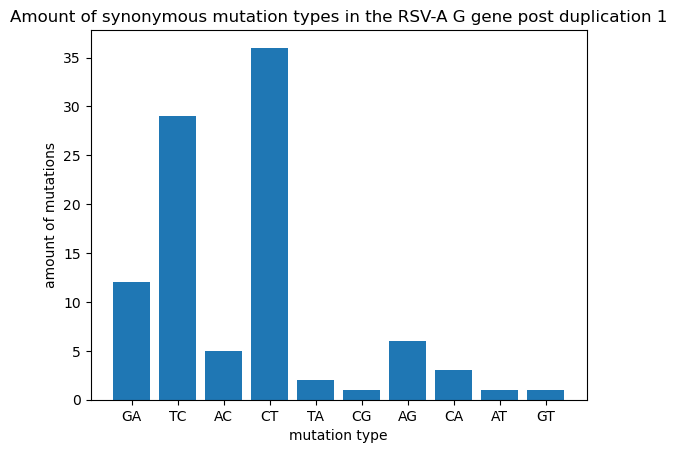

In [31]:
import argparse, math
from Bio import SeqIO, Phylo, Seq
from collections import defaultdict, Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

def separate_duplications(lengthofdupl):
    """
    Divides sequences from duplication file into preduplication, and postduplication copies 1 and 2
    By splitting the files into two parts based on duplication length
    
    inputs: length of duplication (72 for RSV-A and 60 for RSV-B)
            duplication file (fasta file containing aligned duplicated regions)
    outputs:
        - preduplication dictionary 
        - postduplication dictionary (first copy)
        -postduplication dictionary (second copy)
    
    """
    duplicationfile = SeqIO.parse("data/last_reconstruction.fasta", "fasta")
    preduplication, postduplication_1, postduplication_2 = (defaultdict(list) for i in range(3))
    for entry in duplicationfile:
        if '-' not in entry.seq:
            copy_1 = entry.seq[:int(lengthofdupl)][1:-2]
            copy_2 = entry.seq[int(lengthofdupl):][1:-2]
            for i in range(0, len(copy_1), 3):
                postduplication_1[entry.id].append(copy_1[i:i+3])
            for i in range(0, len(copy_2), 3):
                postduplication_2[entry.id].append(copy_2[i:i+3])
        else:
            preduplication_ = entry.seq.replace("-", "")
            if len(preduplication_)== int(lengthofdupl):
                preduplication_ = preduplication_[1:-2]
                for i in range(0, len(preduplication_), 3):
                    preduplication[entry.id].append(preduplication_[i:i+3])
    return(postduplication_1, postduplication_2, preduplication)


def recursive_mutations(treefile, copy):
    """
    Makes basic first reconstruction of common mutations moved to common ancestor. 
    Mutations are split into synonymous and nonsynonymous based on if they result in amino acid change or not. 

    inputs:
        - open newick tree file (rooted at midpoint)
        - copy: dictionary of sequences in a copy of the duplication
    outputs:
        - dictionary synonymous: rudimentary first reconstruction of the common mutations in the copy in dictionary form (synonymous)
        - dictionary nonsynonymous: same as above but nonsynonymous
    """
    synonymous_, nonsynonymous_ = (defaultdict(list) for i in range(2))
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in copy:
            for b in branch:
                if b.name in copy:
                    index = 0
                    for codon_branch, codon_b in zip(copy[branch.name], copy[b.name]):
                        if codon_branch != codon_b:
                            if Seq.translate(codon_branch) == Seq.translate(codon_b):
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        synonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                            else:
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        nonsynonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                        index+=1
    return(nonsynonymous_, synonymous_)

def refine_recursive(treefile, synonymous, nonsynonymous):
    """
    Refines the common mutation function described above. 
    Mutations present in multiple branches are moved further up the tree and exceptions due to sequencing errors are taken into account.

    inputs:
        dictionary synonymous (dictionary of branches and synonymous mutations)
        dictionary nonsynonymous (same as above but nonsynonymous)
        read nwk tree file rooted at midpoint, with the relevant branches

    outputs:
        dictionaries for synonymous and nonsynonymous common mutations.
    
    """
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in synonymous:
            for b in branch:
                if b.name in synonymous:
                    synonymous[b.name] = list(set(synonymous[b.name]).difference(set(synonymous[branch.name])))
        if branch.name in nonsynonymous:
            for b in branch:
                if b.name in synonymous:
                    nonsynonymous[b.name] = list(set(nonsynonymous[b.name]).difference(set(nonsynonymous[branch.name])))
    for branch in treefile.get_nonterminals(order='preorder'):
        sort_branch = []
        for e in nonsynonymous[branch.name]:
            sort_branch.append(str("".join(sorted(e[:2]+ e[2:]))))
        for b in branch:
            if b.name in nonsynonymous:
                sort_b = []
                for entry in nonsynonymous[b.name]:
                    sort_b.append(str("".join((entry[:2]+ entry[2:]))))
                nonsynonymous[b.name] = set(set(sort_b).difference(set(sort_branch)))
    return(nonsynonymous, synonymous)


def mutations(synonymous, nonsynonymous):
    """
    Returns locations of synonymous and nonsynonymous mutations in list format
    
    Inputs:
        synonymous mutation dictionary
        nonsynonymous mutation dictionary
    Outputs:
        - list of nonsynonymous mut location
        - list of synonymous mut location
    """
    syn_, nonsyn_, lst_s, lst_n = ([] for i in range(4))
    for i in synonymous.values():
        ls = list(i)
        for j in ls: lst_s.append(j)
    for item_ in lst_s: syn_.append(int(item_[2:]))
    for i in nonsynonymous.values():
        ls = list(i)
        numbers_ = []
        for it in ls:numbers_.append(it[2:])
        new_numbers_ = list(set(numbers_))
        for j in new_numbers_: lst_n.append(j)
    for item_ in lst_n: nonsyn_.append(int(item_))
    
    return(nonsyn_, syn_)

duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
synonymous_one, nonsynonymous_one  = (defaultdict(list) for i in range(2))
tree_file  = Phylo.read('data/a_tree.nwk', "newick")
tree_file.root_at_midpoint()
tree_file.find_clades()


total_len = tree_file.total_branch_length()
seq_dict = dict()
for record in duplication_file:
    seq_dict[record.id] = record.seq
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
        if '-'*int(72) not in seq_dict[branch.name]:
            with_dupl = branch.total_branch_length()
            break
without_dupl = total_len-with_dupl

copy1, copy2, preduplication = separate_duplications(72)
nonsynonymous_1, synonymous_1 = recursive_mutations(tree_file, copy1)
nonsynonymous_2, synonymous_2 = recursive_mutations(tree_file, copy2)
nonsynonymous_pre, synonymous_pre = recursive_mutations(tree_file, preduplication)
nonsynonymous_1_refined, synonymous_1_refined = refine_recursive(tree_file, nonsynonymous_1, synonymous_1)
nonsynonymous_2_refined, synonymous_2_refined = refine_recursive(tree_file, nonsynonymous_2, synonymous_2)
nonsynonymous_pre_refined, synonymous_pre_refined = refine_recursive(tree_file, nonsynonymous_pre, synonymous_pre)
nonsyn_1, syn_1 = mutations(synonymous_1_refined, nonsynonymous_1_refined)
nonsyn_2, syn_2 = mutations(synonymous_2_refined, nonsynonymous_2_refined)
nonsyn_pre, syn_pre = mutations(synonymous_pre_refined, nonsynonymous_pre_refined)

syn_1_muts = []
for node, muts in synonymous_1_refined.items():
    for m in muts:
        if len(m) == 4:
            syn_1_muts.append(f'{m[:-2]}')
        else:
            syn_1_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_1_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 1")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

    

Text(0, 0.5, 'amount of mutations')

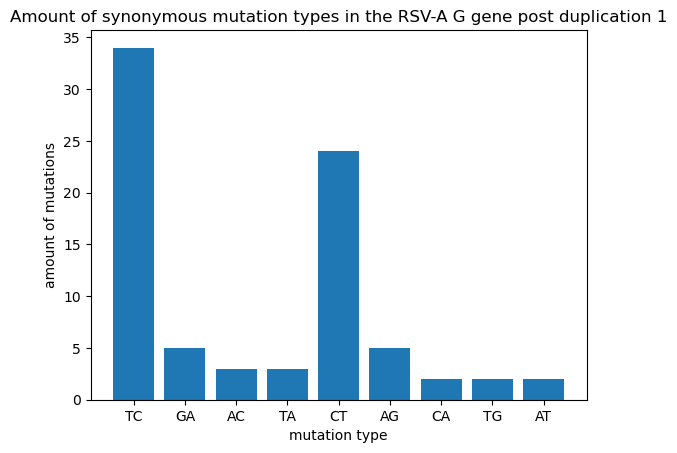

In [32]:
syn_2_muts = []
for node, muts in synonymous_2_refined.items():
    for m in muts:
        if len(m) == 4:
            syn_2_muts.append(f'{m[:-2]}')
        else:
            syn_2_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_2_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 1")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

Text(0, 0.5, 'amount of mutations')

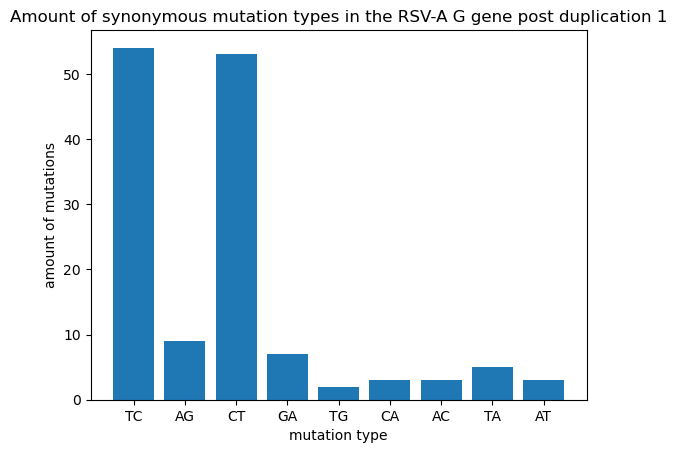

In [33]:
syn_pre_muts = []
for node, muts in synonymous_pre_refined.items():
    for m in muts:
        if 'N' not in m:
            if len(m) == 4:
                syn_pre_muts.append(f'{m[:-2]}')
            else:
                syn_pre_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_pre_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 1")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")